1: Import Libraries & Load Dataset

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

df = pd.read_csv("/content/AmesHousing.csv")

print("Preview of dataset:")
print(df.head())
print("\nShape of dataset:", df.shape)


Preview of dataset:
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  

2: Separate features and target variable

In [15]:
y = df["SalePrice"]
X = df.drop("SalePrice", axis=1)

print("Target variable:", y.name)
print("Number of features:", X.shape[1])


Target variable: SalePrice
Number of features: 81


3: Define preprocessing for numerical and categorical features

In [16]:
num_features = X.select_dtypes(include=["int64","float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ])

print("Number of numeric features:", len(num_features))
print("Number of categorical features:", len(cat_features))


Number of numeric features: 38
Number of categorical features: 43


4: Split the data into training and testing sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (2344, 81)
Testing set size: (586, 81)


5: Train Models & Collect Results

In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring="r2")
    cv_mean = cv_scores.mean()

    results[name] = {"MAE": mae, "RMSE": np.sqrt(rmse), "R2 (Test)": r2, "R2 (CV Mean)": cv_mean} # Calculate RMSE from MSE
    print(f" {name} completed")

results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

 Linear Regression completed
 Decision Tree completed
 Random Forest completed
 Gradient Boosting completed

Model Performance Comparison:
                            MAE          RMSE  R2 (Test)  R2 (CV Mean)
Linear Regression  16034.107897  29635.358986   0.890458      0.858727
Decision Tree      24311.766212  35482.291138   0.842970      0.771311
Random Forest      15909.680734  26423.780102   0.912914      0.886281
Gradient Boosting  15278.078121  26730.799579   0.910879      0.909827


6: Visualization

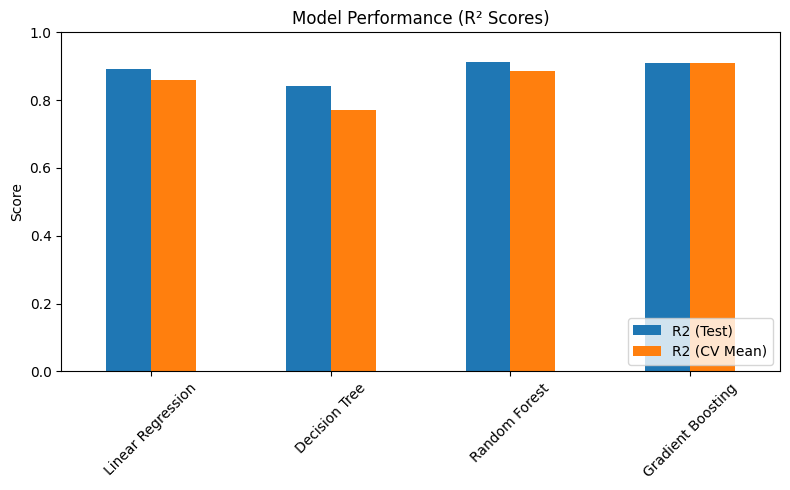

In [21]:
results_df[["R2 (Test)", "R2 (CV Mean)"]].plot(kind="bar", figsize=(8,5))
plt.title("Model Performance (R² Scores)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
